# Code implementation
### Author: Oscar Escudero Arnanz

## Transformer code
### Version: 0

Files already downloaded and verified
Files already downloaded and verified
Fold 1/5
Epoch 1, Train Accuracy: 22.65%, Val Accuracy: 27.90%
Epoch 2, Train Accuracy: 31.10%, Val Accuracy: 34.30%
Epoch 3, Train Accuracy: 35.98%, Val Accuracy: 36.30%
Epoch 4, Train Accuracy: 38.85%, Val Accuracy: 38.30%
Epoch 5, Train Accuracy: 42.25%, Val Accuracy: 38.40%
Epoch 6, Train Accuracy: 46.38%, Val Accuracy: 37.60%
Epoch 7, Train Accuracy: 50.55%, Val Accuracy: 40.10%
Epoch 8, Train Accuracy: 53.92%, Val Accuracy: 41.10%
Epoch 9, Train Accuracy: 58.62%, Val Accuracy: 41.90%
Epoch 10, Train Accuracy: 62.17%, Val Accuracy: 42.60%


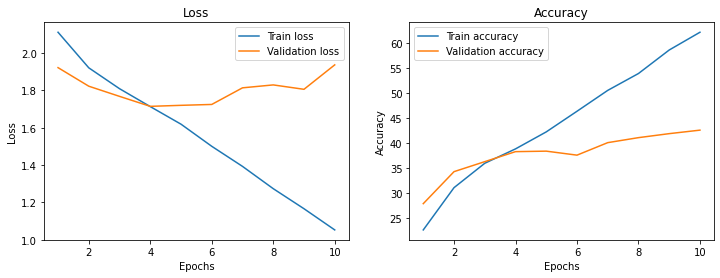

Fold 2/5
Epoch 1, Train Accuracy: 24.20%, Val Accuracy: 26.10%
Epoch 2, Train Accuracy: 32.20%, Val Accuracy: 32.90%
Epoch 3, Train Accuracy: 37.00%, Val Accuracy: 35.00%
Epoch 4, Train Accuracy: 38.55%, Val Accuracy: 39.10%
Epoch 5, Train Accuracy: 43.27%, Val Accuracy: 37.90%
Epoch 6, Train Accuracy: 46.92%, Val Accuracy: 39.20%
Epoch 7, Train Accuracy: 51.05%, Val Accuracy: 40.30%
Epoch 8, Train Accuracy: 55.15%, Val Accuracy: 39.50%
Epoch 9, Train Accuracy: 59.50%, Val Accuracy: 41.70%
Epoch 10, Train Accuracy: 64.50%, Val Accuracy: 40.50%


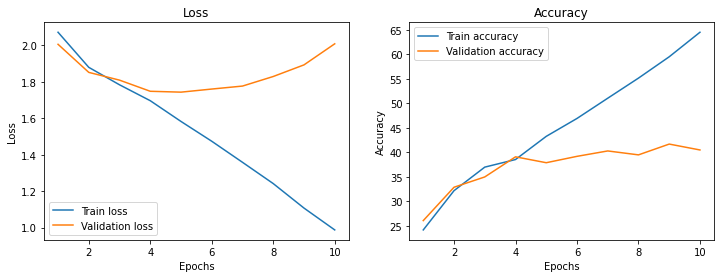

Fold 3/5
Epoch 1, Train Accuracy: 22.50%, Val Accuracy: 31.20%
Epoch 2, Train Accuracy: 31.10%, Val Accuracy: 34.20%
Epoch 3, Train Accuracy: 34.88%, Val Accuracy: 35.70%
Epoch 4, Train Accuracy: 38.10%, Val Accuracy: 40.40%
Epoch 5, Train Accuracy: 41.73%, Val Accuracy: 38.60%
Epoch 6, Train Accuracy: 44.95%, Val Accuracy: 39.40%
Epoch 7, Train Accuracy: 48.17%, Val Accuracy: 40.00%
Epoch 8, Train Accuracy: 53.20%, Val Accuracy: 40.60%
Epoch 9, Train Accuracy: 56.77%, Val Accuracy: 40.60%
Epoch 10, Train Accuracy: 61.00%, Val Accuracy: 39.60%


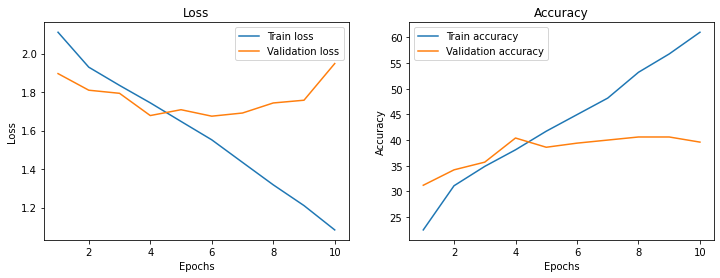

Fold 4/5
Epoch 1, Train Accuracy: 23.23%, Val Accuracy: 30.00%
Epoch 2, Train Accuracy: 31.95%, Val Accuracy: 36.20%
Epoch 3, Train Accuracy: 35.15%, Val Accuracy: 38.40%
Epoch 4, Train Accuracy: 38.88%, Val Accuracy: 37.30%
Epoch 5, Train Accuracy: 41.98%, Val Accuracy: 38.90%
Epoch 6, Train Accuracy: 46.20%, Val Accuracy: 39.50%
Epoch 7, Train Accuracy: 50.75%, Val Accuracy: 39.00%
Epoch 8, Train Accuracy: 55.27%, Val Accuracy: 39.20%
Epoch 9, Train Accuracy: 59.73%, Val Accuracy: 39.30%
Epoch 10, Train Accuracy: 63.88%, Val Accuracy: 38.00%


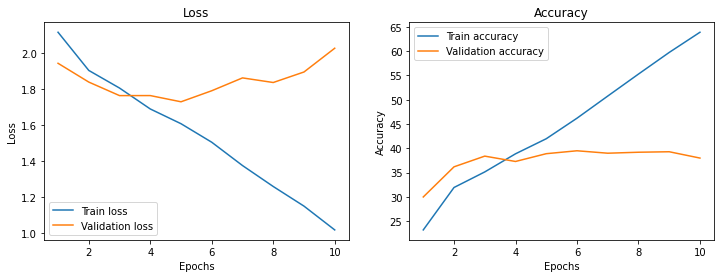

Fold 5/5
Epoch 1, Train Accuracy: 22.82%, Val Accuracy: 27.90%
Epoch 2, Train Accuracy: 30.80%, Val Accuracy: 34.00%
Epoch 3, Train Accuracy: 34.12%, Val Accuracy: 34.50%
Epoch 4, Train Accuracy: 38.65%, Val Accuracy: 38.90%
Epoch 5, Train Accuracy: 42.98%, Val Accuracy: 38.00%
Epoch 6, Train Accuracy: 46.50%, Val Accuracy: 37.20%
Epoch 7, Train Accuracy: 50.80%, Val Accuracy: 38.40%
Epoch 8, Train Accuracy: 55.65%, Val Accuracy: 37.80%
Epoch 9, Train Accuracy: 60.42%, Val Accuracy: 39.30%
Epoch 10, Train Accuracy: 63.90%, Val Accuracy: 39.20%


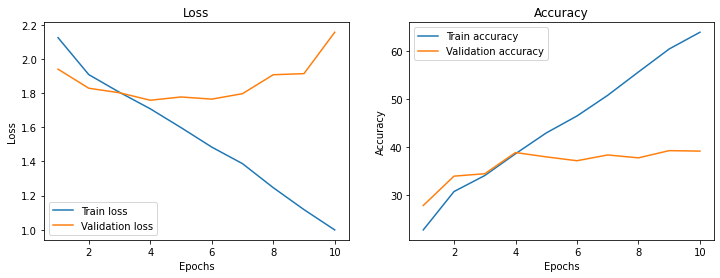

Average Train Accuracy across 5 folds: 63.09%
Average Val Accuracy across 5 folds: 39.98%
Accuracy of the network on the 1000 test images: 36.50%


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from sklearn.model_selection import KFold
import numpy as np
import matplotlib.pyplot as plt

# Model parameters
input_shape = (32, 32, 3)  # Size of CIFAR-10 images
patch_size = 4  # Patch size to divide the image
num_patches = (input_shape[0] // patch_size) ** 2
projection_dim = 64  # Increased for better capacity
num_heads = 4  # Increased for better capacity
transformer_layers = 4  # Increased for greater depth
mlp_head_units = [128, 64]  # Increased for better capacity
num_classes = 10  # CIFAR-10 has 10 classes
dropout_rate = 0.1

# Load and preprocess CIFAR-10 data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
# Use only a small subset of the training set
trainset, _ = torch.utils.data.random_split(trainset, [5000, len(trainset) - 5000])  # 5000 samples for training
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
# Use only a small subset of the test set
testset, _ = torch.utils.data.random_split(testset, [1000, len(testset) - 1000])  # 1000 samples for testing

# Define the MLP class
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_units, dropout_rate):
        super(MLP, self).__init__()
        layers = []
        for units in hidden_units:
            layers.append(nn.Linear(input_dim, units))
            layers.append(nn.GELU())
            layers.append(nn.Dropout(dropout_rate))
            input_dim = units
        self.mlp = nn.Sequential(*layers)

    def forward(self, x):
        return self.mlp(x)

# Patch Embedding
class PatchEmbedding(nn.Module):
    def __init__(self, num_patches, projection_dim, patch_dim):
        super(PatchEmbedding, self).__init__()
        self.projection = nn.Linear(patch_dim, projection_dim)
        self.position_embedding = nn.Embedding(num_patches, projection_dim)

    def forward(self, patches):
        positions = torch.arange(0, patches.size(1), device=patches.device).unsqueeze(0)
        return self.projection(patches) + self.position_embedding(positions)

# Transformer Encoder
class TransformerEncoder(nn.Module):
    def __init__(self, projection_dim, num_heads, ff_dim, dropout_rate):
        super(TransformerEncoder, self).__init__()
        self.layer_norm1 = nn.LayerNorm(projection_dim)
        self.attention = nn.MultiheadAttention(embed_dim=projection_dim, num_heads=num_heads, dropout=dropout_rate)
        self.dropout1 = nn.Dropout(dropout_rate)
        
        self.layer_norm2 = nn.LayerNorm(projection_dim)
        self.mlp = MLP(projection_dim, [ff_dim], dropout_rate)
        self.dropout2 = nn.Dropout(dropout_rate)

    def forward(self, x):
        x_norm1 = self.layer_norm1(x)
        attention_output, _ = self.attention(x_norm1, x_norm1, x_norm1)
        x = x + self.dropout1(attention_output)
        
        x_norm2 = self.layer_norm2(x)
        mlp_output = self.mlp(x_norm2)
        return x + self.dropout2(mlp_output)

# Vision Transformer model
class VisionTransformer(nn.Module):
    def __init__(self, input_shape, patch_size, num_patches, projection_dim, num_heads, transformer_layers, mlp_head_units, num_classes, dropout_rate):
        super(VisionTransformer, self).__init__()
        self.patch_size = patch_size
        patch_dim = input_shape[2] * patch_size * patch_size

        self.patch_embedding = PatchEmbedding(num_patches, projection_dim, patch_dim)

        self.transformer_layers = nn.ModuleList([
            TransformerEncoder(projection_dim, num_heads, projection_dim, dropout_rate)
            for _ in range(transformer_layers)
        ])

        self.layer_norm = nn.LayerNorm(projection_dim)
        self.mlp_head = MLP(projection_dim * num_patches, mlp_head_units, dropout_rate)
        self.classifier = nn.Linear(mlp_head_units[-1], num_classes)

    def forward(self, x):
        batch_size = x.size(0)
        x = self.extract_patches(x)
        x = self.patch_embedding(x)
        
        for layer in self.transformer_layers:
            x = layer(x)
        
        x = self.layer_norm(x)
        x = x.flatten(1)
        x = self.mlp_head(x)
        x = self.classifier(x)
        return x

    def extract_patches(self, images):
        batch_size = images.size(0)
        patches = images.unfold(2, self.patch_size, self.patch_size).unfold(3, self.patch_size, self.patch_size)
        patches are contiguous().view(batch_size, -1, self.patch_size * self.patch_size * images.size(1))
        return patches

# Configure the device
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

# Number of folds for cross-validation
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Convert data to tensors
X_data = np.array([trainset[i][0].numpy() for i in range(len(trainset))])
y_data = np.array([trainset[i][1] for i in range(len(trainset))])

# Variables to store results of each fold
fold_train_accuracies = []
fold_val_accuracies = []

# Cross-validation
for fold, (train_idx, val_idx) in enumerate(kf.split(X_data)):
    print(f"Fold {fold + 1}/{n_splits}")
    
    # Training and validation subsets for this fold
    X_train_fold = torch.tensor(X_data[train_idx], dtype=torch.float32)
    y_train_fold = torch.tensor(y_data[train_idx], dtype=torch.long)
    X_val_fold = torch.tensor(X_data[val_idx], dtype=torch.float32)
    y_val_fold = torch.tensor(y_data[val_idx], dtype=torch.long)
    
    # Create loaders
    trainloader_fold = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_train_fold, y_train_fold), batch_size=8, shuffle=True)
    valloader_fold = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_val_fold, y_val_fold), batch_size=8, shuffle=False)
    
    # Initialize the model
    model = VisionTransformer(
        input_shape=input_shape,
        patch_size=patch_size,
        num_patches=num_patches,
        projection_dim=projection_dim,
        num_heads=num_heads,
        transformer_layers=transformer_layers,
        mlp_head_units=mlp_head_units,
        num_classes=num_classes,
        dropout_rate=dropout_rate
    )
    model.to(device)
    
    # Loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    # Store losses and accuracies for plotting
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    # Train the model for this fold
    for epoch in range(10):  # Increased to 10 epochs
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for i, (inputs, labels) in enumerate(trainloader_fold):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_loss = running_loss / len(trainloader_fold)
        train_accuracy = 100 * correct_train / total_train

        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # Evaluate on the validation set for this fold
        model.eval()
        running_val_loss = 0.0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for inputs, labels in valloader_fold:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        val_loss = running_val_loss / len(valloader_fold)
        val_accuracy = 100 * correct_val / total_val

        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch + 1}, Train Accuracy: {train_accuracy:.2f}%, Val Accuracy: {val_accuracy:.2f}%")

    fold_train_accuracies.append(train_accuracy)
    fold_val_accuracies.append(val_accuracy)

    # Plot losses and accuracies
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train loss')
    plt.plot(epochs, val_losses, label='Validation loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Train accuracy')
    plt.plot(epochs, val_accuracies, label='Validation accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

# Calculate the average metrics across folds
print(f"Average Train Accuracy across {n_splits} folds: {np.mean(fold_train_accuracies):.2f}%")
print(f"Average Val Accuracy across {n_splits} folds: {np.mean(fold_val_accuracies):.2f}%")

# Evaluate the model on the test set
testloader = torch.utils.data.DataLoader(testset, batch_size=8, shuffle=False)
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = 100 * correct / total
print(f"Accuracy of the network on the 1000 test images: {test_accuracy:.2f}%")


## Transformer code with MoE
### Version: 1

Files already downloaded and verified
Files already downloaded and verified
Fold 1/5
Epoch 1, Train Accuracy: 10.10%, Val Accuracy: 10.40%
Epoch 2, Train Accuracy: 9.93%, Val Accuracy: 10.40%
Epoch 3, Train Accuracy: 10.65%, Val Accuracy: 11.30%
Epoch 4, Train Accuracy: 10.93%, Val Accuracy: 11.30%
Epoch 5, Train Accuracy: 10.90%, Val Accuracy: 11.30%
Epoch 6, Train Accuracy: 10.90%, Val Accuracy: 11.30%
Epoch 7, Train Accuracy: 10.90%, Val Accuracy: 11.30%
Epoch 8, Train Accuracy: 10.90%, Val Accuracy: 11.30%
Epoch 9, Train Accuracy: 10.90%, Val Accuracy: 11.30%
Epoch 10, Train Accuracy: 10.90%, Val Accuracy: 11.30%


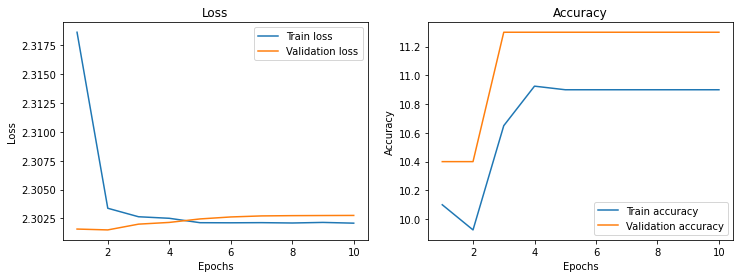

Fold 2/5
Epoch 1, Train Accuracy: 10.45%, Val Accuracy: 10.80%
Epoch 2, Train Accuracy: 11.03%, Val Accuracy: 10.80%
Epoch 3, Train Accuracy: 11.03%, Val Accuracy: 10.80%
Epoch 4, Train Accuracy: 11.03%, Val Accuracy: 10.80%
Epoch 5, Train Accuracy: 11.03%, Val Accuracy: 10.80%
Epoch 6, Train Accuracy: 11.03%, Val Accuracy: 10.80%
Epoch 7, Train Accuracy: 11.03%, Val Accuracy: 10.80%
Epoch 8, Train Accuracy: 11.03%, Val Accuracy: 10.80%
Epoch 9, Train Accuracy: 11.03%, Val Accuracy: 10.80%
Epoch 10, Train Accuracy: 11.03%, Val Accuracy: 10.80%


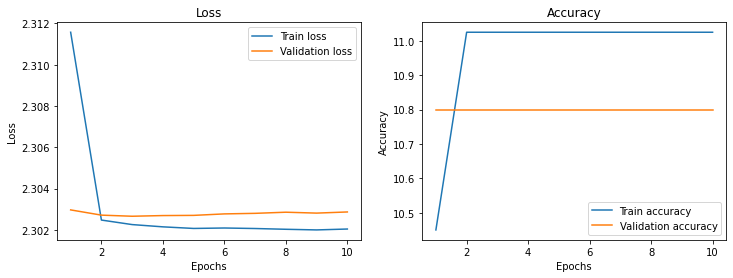

Fold 3/5
Epoch 1, Train Accuracy: 20.23%, Val Accuracy: 26.50%
Epoch 2, Train Accuracy: 25.90%, Val Accuracy: 30.30%
Epoch 3, Train Accuracy: 28.30%, Val Accuracy: 31.80%
Epoch 4, Train Accuracy: 30.15%, Val Accuracy: 30.60%
Epoch 5, Train Accuracy: 32.98%, Val Accuracy: 34.20%
Epoch 6, Train Accuracy: 34.88%, Val Accuracy: 33.90%
Epoch 7, Train Accuracy: 38.60%, Val Accuracy: 34.30%
Epoch 8, Train Accuracy: 41.77%, Val Accuracy: 39.20%
Epoch 9, Train Accuracy: 45.52%, Val Accuracy: 38.80%
Epoch 10, Train Accuracy: 48.48%, Val Accuracy: 38.50%


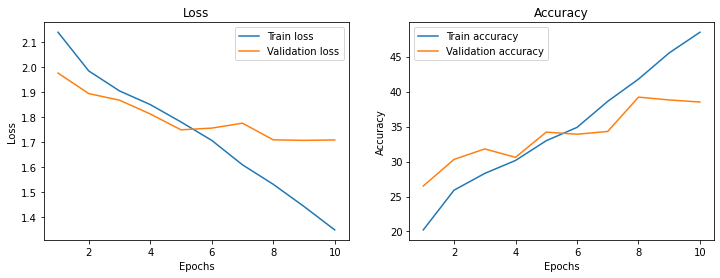

Fold 4/5
Epoch 1, Train Accuracy: 12.97%, Val Accuracy: 12.70%
Epoch 2, Train Accuracy: 16.23%, Val Accuracy: 17.40%
Epoch 3, Train Accuracy: 20.57%, Val Accuracy: 22.10%
Epoch 4, Train Accuracy: 21.82%, Val Accuracy: 23.60%
Epoch 5, Train Accuracy: 23.52%, Val Accuracy: 21.00%
Epoch 6, Train Accuracy: 24.23%, Val Accuracy: 22.20%
Epoch 7, Train Accuracy: 25.57%, Val Accuracy: 26.10%
Epoch 8, Train Accuracy: 27.50%, Val Accuracy: 27.70%
Epoch 9, Train Accuracy: 29.48%, Val Accuracy: 27.10%
Epoch 10, Train Accuracy: 32.35%, Val Accuracy: 27.70%


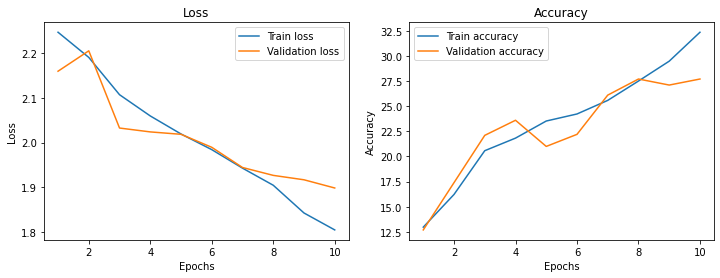

Fold 5/5
Epoch 1, Train Accuracy: 21.18%, Val Accuracy: 26.00%
Epoch 2, Train Accuracy: 25.95%, Val Accuracy: 28.80%
Epoch 3, Train Accuracy: 29.90%, Val Accuracy: 28.20%
Epoch 4, Train Accuracy: 32.25%, Val Accuracy: 33.20%
Epoch 5, Train Accuracy: 35.52%, Val Accuracy: 35.50%
Epoch 6, Train Accuracy: 37.40%, Val Accuracy: 36.60%
Epoch 7, Train Accuracy: 40.15%, Val Accuracy: 37.90%
Epoch 8, Train Accuracy: 41.95%, Val Accuracy: 36.40%
Epoch 9, Train Accuracy: 45.52%, Val Accuracy: 36.40%
Epoch 10, Train Accuracy: 47.67%, Val Accuracy: 34.90%


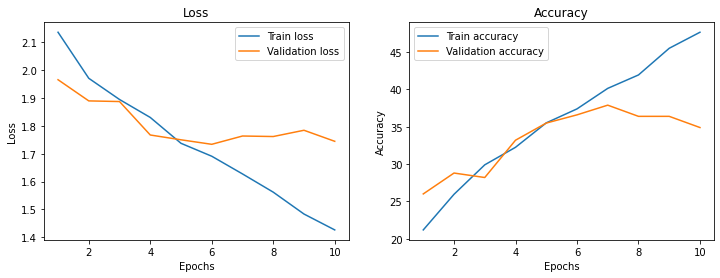

Average Train Accuracy across 5 folds: 30.09%
Average Val Accuracy across 5 folds: 24.64%
Accuracy of the network on the 1000 test images: 39.30%


In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from sklearn.model_selection import KFold
import numpy as np
import matplotlib.pyplot as plt

# Model parameters
input_shape = (32, 32, 3)
patch_size = 4
num_patches = (input_shape[0] // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_layers = 4
num_experts = 3  # Number of experts in MoE
mlp_head_units = [128, 64]
num_classes = 10
dropout_rate = 0.1
num_experts = 3

# Load and preprocess CIFAR-10 data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainset, _ = torch.utils.data.random_split(trainset, [5000, len(trainset) - 5000])
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testset, _ = torch.utils.data.random_split(testset, [1000, len(testset) - 1000])

# Define the MoE (Mixture of Experts) class
class MoE(nn.Module):
    def __init__(self, input_dim, output_dim, num_experts, dropout_rate):
        super(MoE, self).__init__()
        self.experts = nn.ModuleList([nn.Sequential(
            nn.Linear(input_dim, output_dim),
            nn.GELU(),
            nn.Dropout(dropout_rate)
        ) for _ in range(num_experts)])
        self.gating_network = nn.Sequential(
            nn.Linear(input_dim, num_experts),
            nn.Softmax(dim=-1)
        )

    def forward(self, x):
        gate_values = self.gating_network(x)
        expert_outputs = torch.stack([expert(x) for expert in self.experts], dim=-1)
        output = torch.sum(gate_values.unsqueeze(-2) * expert_outputs, dim=-1)
        return output

# Patch Embedding
class PatchEmbedding(nn.Module):
    def __init__(self, num_patches, projection_dim, patch_dim):
        super(PatchEmbedding, self).__init__()
        self.projection = nn.Linear(patch_dim, projection_dim)
        self.position_embedding = nn.Embedding(num_patches, projection_dim)

    def forward(self, patches):
        positions = torch.arange(0, patches.size(1), device=patches.device).unsqueeze(0)
        return self.projection(patches) + self.position_embedding(positions)

# Transformer Encoder with MoE
class TransformerEncoder(nn.Module):
    def __init__(self, projection_dim, num_heads, ff_dim, num_experts, dropout_rate):
        super(TransformerEncoder, self).__init__()
        self.layer_norm1 = nn.LayerNorm(projection_dim)
        self.attention = nn.MultiheadAttention(embed_dim=projection_dim, num_heads=num_heads, dropout=dropout_rate)
        self.dropout1 = nn.Dropout(dropout_rate)
        
        self.layer_norm2 = nn.LayerNorm(projection_dim)
        self.moe = MoE(projection_dim, ff_dim, num_experts, dropout_rate)
        self.dropout2 = nn.Dropout(dropout_rate)

    def forward(self, x):
        x_norm1 = self.layer_norm1(x)
        attention_output, _ = self.attention(x_norm1, x_norm1, x_norm1)
        x = x + self.dropout1(attention_output)
        
        x_norm2 = self.layer_norm2(x)
        moe_output = self.moe(x_norm2)
        return x + self.dropout2(moe_output)

# Vision Transformer with MoE model
class VisionTransformer(nn.Module):
    def __init__(self, input_shape, patch_size, num_patches, projection_dim, num_heads, transformer_layers, mlp_head_units, num_classes, dropout_rate, num_experts):
        super(VisionTransformer, self).__init__()
        self.patch_size = patch_size
        patch_dim = input_shape[2] * patch_size * patch_size

        self.patch_embedding = PatchEmbedding(num_patches, projection_dim, patch_dim)

        self.transformer_layers = nn.ModuleList([
            TransformerEncoder(projection_dim, num_heads, projection_dim, num_experts, dropout_rate)
            for _ in range(transformer_layers)
        ])

        self.layer_norm = nn.LayerNorm(projection_dim)
        self.mlp_head = MoE(projection_dim * num_patches, mlp_head_units[-1], num_experts, dropout_rate)
        self.classifier = nn.Linear(mlp_head_units[-1], num_classes)

    def forward(self, x):
        batch_size = x.size(0)
        x = self.extract_patches(x)
        x = self.patch_embedding(x)
        
        for layer in self.transformer_layers:
            x = layer(x)
        
        x = self.layer_norm(x)
        x = x.flatten(1)
        x = self.mlp_head(x)
        x = self.classifier(x)
        return x

    def extract_patches(self, images):
        batch_size = images.size(0)
        patches = images.unfold(2, self.patch_size, self.patch_size).unfold(3, self.patch_size, self.patch_size)
        patches are contiguous().view(batch_size, -1, self.patch_size * self.patch_size * images.size(1))
        return patches

# Configure the device
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

# Number of folds for cross-validation
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Convert data to tensors
X_data = np.array([trainset[i][0].numpy() for i in range(len(trainset))])
y_data = np.array([trainset[i][1] for i in range(len(trainset))])

# Variables to store results of each fold
fold_train_accuracies = []
fold_val_accuracies = []

# Cross-validation
for fold, (train_idx, val_idx) in enumerate(kf.split(X_data)):
    print(f"Fold {fold + 1}/{n_splits}")
    
    # Training and validation subsets for this fold
    X_train_fold = torch.tensor(X_data[train_idx], dtype=torch.float32)
    y_train_fold = torch.tensor(y_data[train_idx], dtype=torch.long)
    X_val_fold = torch.tensor(X_data[val_idx], dtype=torch.float32)
    y_val_fold = torch.tensor(y_data[val_idx], dtype=torch.long)
    
    # Create loaders
    trainloader_fold = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_train_fold, y_train_fold), batch_size=8, shuffle=True)
    valloader_fold = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_val_fold, y_val_fold), batch_size=8, shuffle=False)
    
    # Initialize the model
    model = VisionTransformer(
        input_shape=input_shape,
        patch_size=patch_size,
        num_patches=num_patches,
        projection_dim=projection_dim,
        num_heads=num_heads,
        transformer_layers=transformer_layers,
        mlp_head_units=mlp_head_units,
        num_classes=num_classes,
        dropout_rate=dropout_rate,
        num_experts=num_experts  # Add this argument
    )
    model.to(device)
    
    # Loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    # Store losses and accuracies for plotting
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    # Train the model for this fold
    for epoch in range(10):  # Increased to 10 epochs
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for i, (inputs, labels) in enumerate(trainloader_fold):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_loss = running_loss / len(trainloader_fold)
        train_accuracy = 100 * correct_train / total_train

        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # Evaluate on the validation set for this fold
        model.eval()
        running_val_loss = 0.0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for inputs, labels in valloader_fold:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        val_loss = running_val_loss / len(valloader_fold)
        val_accuracy = 100 * correct_val / total_val

        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch + 1}, Train Accuracy: {train_accuracy:.2f}%, Val Accuracy: {val_accuracy:.2f}%")

    fold_train_accuracies.append(train_accuracy)
    fold_val_accuracies.append(val_accuracy)

    # Plot losses and accuracies
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train loss')
    plt.plot(epochs, val_losses, label='Validation loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Train accuracy')
    plt.plot(epochs, val_accuracies, label='Validation accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

# Calculate the average metrics across folds
print(f"Average Train Accuracy across {n_splits} folds: {np.mean(fold_train_accuracies):.2f}%")
print(f"Average Val Accuracy across {n_splits} folds: {np.mean(fold_val_accuracies)::.2f}%")

# Evaluate the model on the test set
testloader = torch.utils.data.DataLoader(testset, batch_size=8, shuffle=False)
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = 100 * correct / total
print(f"Accuracy of the network on the 1000 test images: {test_accuracy:.2f}%")


## Transformers "final version"
### Version: 2

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from sklearn.model_selection import KFold
import numpy as np
import matplotlib.pyplot as plt

# Model parameters that remain constant
input_shape = (32, 32, 3)
patch_size = 4
num_patches = (input_shape[0] // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_layers = 4
mlp_head_units = [128, 64]
num_classes = 10
dropout_rate = 0.1
num_epochs = 50

# Different numbers of experts to evaluate
num_experts_list = [5, 6, 7, 8]

# Load and preprocess CIFAR-10 data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainset, _ = torch.utils.data.random_split(trainset, [5000, len(trainset) - 5000])
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testset, _ = torch.utils.data.random_split(testset, [1000, len(testset) - 1000])

# Define the MoE (Mixture of Experts) class
class MoE(nn.Module):
    def __init__(self, input_dim, output_dim, num_experts, dropout_rate):
        super(MoE, self).__init__()
        self.experts = nn.ModuleList([nn.Sequential(
            nn.Linear(input_dim, output_dim),
            nn.GELU(),
            nn.Dropout(dropout_rate)
        ) for _ in range(num_experts)])
        self.gating_network = nn.Sequential(
            nn.Linear(input_dim, num_experts),
            nn.Softmax(dim=-1)
        )

    def forward(self, x):
        gate_values = self.gating_network(x)
        expert_outputs = torch.stack([expert(x) for expert in self.experts], dim=-1)
        output = torch.sum(gate_values.unsqueeze(-2) * expert_outputs, dim=-1)
        return output

# Patch Embedding
class PatchEmbedding(nn.Module):
    def __init__(self, num_patches, projection_dim, patch_dim):
        super(PatchEmbedding, self).__init__()
        self.projection = nn.Linear(patch_dim, projection_dim)
        self.position_embedding = nn.Embedding(num_patches, projection_dim)

    def forward(self, patches):
        positions = torch.arange(0, patches.size(1), device=patches.device).unsqueeze(0)
        return self.projection(patches) + self.position_embedding(positions)

# Transformer Encoder with MoE
class TransformerEncoder(nn.Module):
    def __init__(self, projection_dim, num_heads, ff_dim, num_experts, dropout_rate):
        super(TransformerEncoder, self).__init__()
        self.layer_norm1 = nn.LayerNorm(projection_dim)
        self.attention = nn.MultiheadAttention(embed_dim=projection_dim, num_heads=num_heads, dropout=dropout_rate)
        self.dropout1 = nn.Dropout(dropout_rate)
        
        self.layer_norm2 = nn.LayerNorm(projection_dim)
        self.moe = MoE(projection_dim, ff_dim, num_experts, dropout_rate)
        self.dropout2 = nn.Dropout(dropout_rate)

    def forward(self, x):
        x_norm1 = self.layer_norm1(x)
        attention_output, _ = self.attention(x_norm1, x_norm1, x_norm1)
        x = x + self.dropout1(attention_output)
        
        x_norm2 = self.layer_norm2(x)
        moe_output = self.moe(x_norm2)
        return x + self.dropout2(moe_output)

# Vision Transformer with MoE model
class VisionTransformer(nn.Module):
    def __init__(self, input_shape, patch_size, num_patches, projection_dim, num_heads, transformer_layers, mlp_head_units, num_classes, dropout_rate, num_experts):
        super(VisionTransformer, self).__init__()
        self.patch_size = patch_size
        patch_dim = input_shape[2] * patch_size * patch_size

        self.patch_embedding = PatchEmbedding(num_patches, projection_dim, patch_dim)

        self.transformer_layers = nn.ModuleList([
            TransformerEncoder(projection_dim, num_heads, projection_dim, num_experts, dropout_rate)
            for _ in range(transformer_layers)
        ])

        self.layer_norm = nn.LayerNorm(projection_dim)
        self.mlp_head = MoE(projection_dim * num_patches, mlp_head_units[-1], num_experts, dropout_rate)
        self.classifier = nn.Linear(mlp_head_units[-1], num_classes)

    def forward(self, x):
        batch_size = x.size(0)
        x = self.extract_patches(x)
        x = self.patch_embedding(x)
        
        for layer in self.transformer_layers:
            x = layer(x)
        
        x = self.layer_norm(x)
        x = x.flatten(1)
        x = self.mlp_head(x)
        x = self.classifier(x)
        return x

    def extract_patches(self, images):
        batch_size = images.size(0)
        patches = images.unfold(2, self.patch_size, self.patch_size).unfold(3, self.patch_size, self.patch_size)
        patches are contiguous().view(batch_size, -1, self.patch_size * self.patch_size * images.size(1))
        return patches

# Configure the device
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

# Number of folds for cross-validation
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Convert data to tensors
X_data = np.array([trainset[i][0].numpy() for i in range(len(trainset))])
y_data = np.array([trainset[i][1] for i in range(len(trainset))])

# Evaluate for each value of num_experts
results = []

for num_experts in num_experts_list:
    print(f"\nEvaluating num_experts = {num_experts}\n")
    
    fold_train_accuracies = []
    fold_val_accuracies = []
    
    for fold, (train_idx, val_idx) in enumerate(kf.split(X_data)):
        print(f"Fold {fold + 1}/{n_splits}")
        
        # Training and validation subsets for this fold
        X_train_fold = torch.tensor(X_data[train_idx], dtype=torch.float32)
        y_train_fold = torch.tensor(y_data[train_idx], dtype=torch.long)
        X_val_fold = torch.tensor(X_data[val_idx], dtype=torch.float32)
        y_val_fold = torch.tensor(y_data[val_idx], dtype=torch.long)
        
        # Create loaders
        trainloader_fold = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_train_fold, y_train_fold), batch_size=8, shuffle=True)
        valloader_fold = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_val_fold, y_val_fold), batch_size=8, shuffle=False)
        
        # Initialize the model
        model = VisionTransformer(
            input_shape=input_shape,
            patch_size=patch_size,
            num_patches=num_patches,
            projection_dim=projection_dim,
            num_heads=num_heads,
            transformer_layers=transformer_layers,
            mlp_head_units=mlp_head_units,
            num_classes=num_classes,
            dropout_rate=dropout_rate,
            num_experts=num_experts  # Evaluated hyperparameter
        )
        model.to(device)
        
        # Loss function and optimizer
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        
        # Train the model for this fold
        for epoch in range(num_epochs):
            model.train()
            running_loss = 0.0
            correct_train = 0
            total_train = 0

            for i, (inputs, labels) in enumerate(trainloader_fold):
                inputs, labels = inputs.to(device), labels.to(device)

                optimizer.zero_grad()

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_train += labels.size(0)
                correct_train += (predicted == labels).sum().item()

            train_loss = running_loss / len(trainloader_fold)
            train_accuracy = 100 * correct_train / total_train

            # Evaluate on the validation set for this fold
            model.eval()
            running_val_loss = 0.0
            correct_val = 0
            total_val = 0
            with torch.no_grad():
                for inputs, labels in valloader_fold:
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    running_val_loss += loss.item()

                    _, predicted = torch.max(outputs.data, 1)
                    total_val += labels.size(0)
                    correct_val += (predicted == labels).sum().item()

            val_loss = running_val_loss / len(valloader_fold)
            val_accuracy = 100 * correct_val / total_val

        fold_train_accuracies.append(train_accuracy)
        fold_val_accuracies.append(val_accuracy)

    # Average results for the evaluated number of experts
    avg_train_accuracy = np.mean(fold_train_accuracies)
    avg_val_accuracy = np.mean(fold_val_accuracies)
    results.append((num_experts, avg_train_accuracy, avg_val_accuracy))
    print(f"num_experts = {num_experts}, Avg Train Accuracy: {avg_train_accuracy:.2f}%, Avg Val Accuracy: {avg_val_accuracy:.2f}%")

# Display results for all evaluated num_experts
print("\nFinal Results for different values of num_experts:")
for num_experts, train_acc, val_acc in results:
    print(f"num_experts = {num_experts}: Train Accuracy = {train_acc:.2f}%, Validation Accuracy = {val_acc:.2f}%")

# Select the best number of experts based on validation accuracy
best_num_experts = max(results, key=lambda x: x[2])[0]
print(f"\nBest number of experts based on validation accuracy: {best_num_experts}")

# Evaluate the best model on the test set
model = VisionTransformer(
    input_shape=input_shape,
    patch_size=patch_size,
    num_patches=num_patches,
    projection_dim=projection_dim,
    num_heads=num_heads,
    transformer_layers=transformer_layers,
    mlp_head_units=mlp_head_units,
    num_classes=num_classes,
    dropout_rate=dropout_rate,
    num_experts=best_num_experts  # Use the best number of experts
)
model.to(device)

testloader = torch.utils.data.DataLoader(testset, batch_size=8, shuffle=False)
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = 100 * correct / total
print(f"\nAccuracy of the best model on the 1000 test images: {test_accuracy:.2f}%")

Files already downloaded and verified
Files already downloaded and verified

Evaluando num_experts = 5

Fold 1/5
Fold 2/5
Fold 3/5
Fold 4/5
Fold 5/5
num_experts = 5, Avg Train Accuracy: 73.04%, Avg Val Accuracy: 33.04%

Evaluando num_experts = 6

Fold 1/5
Fold 2/5
Fold 3/5
Fold 4/5
Fold 5/5
num_experts = 6, Avg Train Accuracy: 50.61%, Avg Val Accuracy: 25.68%

Evaluando num_experts = 7

Fold 1/5
Fold 2/5
Fold 3/5
Fold 4/5
Fold 5/5
num_experts = 7, Avg Train Accuracy: 72.91%, Avg Val Accuracy: 32.56%

Evaluando num_experts = 8

Fold 1/5
Fold 2/5
Fold 3/5
Fold 4/5
Fold 5/5
num_experts = 8, Avg Train Accuracy: 73.22%, Avg Val Accuracy: 32.20%

Resultados Finales para diferentes valores de num_experts:
num_experts = 5: Train Accuracy = 73.04%, Validation Accuracy = 33.04%
num_experts = 6: Train Accuracy = 50.61%, Validation Accuracy = 25.68%
num_experts = 7: Train Accuracy = 72.91%, Validation Accuracy = 32.56%
num_experts = 8: Train Accuracy = 73.22%, Validation Accuracy = 32.20%

Mejor n